In [9]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance')
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

In [10]:
# Get more data
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [11]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '31/12/2019'
end_date = '13/07/2021'
time_frame = '1h'
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [12]:
btc_df = raw_df.copy()

In [13]:
# Drop NAs and calculate daily percent return
btc_df["hourly_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(24)

# Display sample data
btc_df.head(10)

,Open,High,Low,Close,Volume,hourly_return,target
Timestamp,,,,,,,
2019-12-31 00:00:00,7246.00,7255.00,7200.00,7251.00,1792.533352,NaN,NaN
2019-12-31 01:00:00,7251.00,7269.00,7245.00,7265.40,906.250932,0.001986,NaN
2019-12-31 02:00:00,7264.96,7266.74,7225.34,7246.99,735.587624,-0.002534,NaN
2019-12-31 03:00:00,7247.01,7250.00,7221.00,7236.39,622.927341,-0.001463,NaN
2019-12-31 04:00:00,7236.60,7263.15,7228.40,7240.37,774.064951,0.000550,NaN
2019-12-31 05:00:00,7240.21,7268.48,7240.09,7264.06,650.479214,0.003272,NaN
2019-12-31 06:00:00,7264.05,7267.00,7243.94,7244.98,667.349400,-0.002627,NaN
2019-12-31 07:00:00,7244.72,7255.02,7236.01,7250.37,572.777026,0.000744,NaN
2019-12-31 08:00:00,7250.30,7250.54,7223.36,7229.18,910.421744,-0.002923,NaN


### Moving Averages

In [14]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]

# Display sample data
btc_df.head(10)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Timestamp,,,,,,,,,,,,
2019-12-31 00:00:00,7246.00,7255.00,7200.00,7251.00,1792.533352,NaN,NaN,7251.000000,7251.000000,0.0,0.0,0.0
2019-12-31 01:00:00,7251.00,7269.00,7245.00,7265.40,906.250932,0.001986,NaN,7260.600000,7258.449433,1.0,0.0,1.0
2019-12-31 02:00:00,7264.96,7266.74,7225.34,7246.99,735.587624,-0.002534,NaN,7252.822857,7254.362010,0.0,-1.0,-1.0
2019-12-31 03:00:00,7247.01,7250.00,7221.00,7236.39,622.927341,-0.001463,NaN,7244.058667,7249.391649,0.0,-1.0,-1.0
2019-12-31 04:00:00,7236.60,7263.15,7228.40,7240.37,774.064951,0.000550,NaN,7242.154839,7247.328942,0.0,-1.0,-1.0
2019-12-31 05:00:00,7240.21,7268.48,7240.09,7264.06,650.479214,0.003272,NaN,7253.281270,7250.621938,1.0,0.0,1.0
2019-12-31 06:00:00,7264.05,7267.00,7243.94,7244.98,667.349400,-0.002627,NaN,7249.097953,7249.639117,0.0,-1.0,-1.0
2019-12-31 07:00:00,7244.72,7255.02,7236.01,7250.37,572.777026,0.000744,NaN,7249.736471,7249.754106,0.0,-1.0,-1.0
2019-12-31 08:00:00,7250.30,7250.54,7223.36,7229.18,910.421744,-0.002923,NaN,7239.438121,7246.785463,0.0,-1.0,-1.0


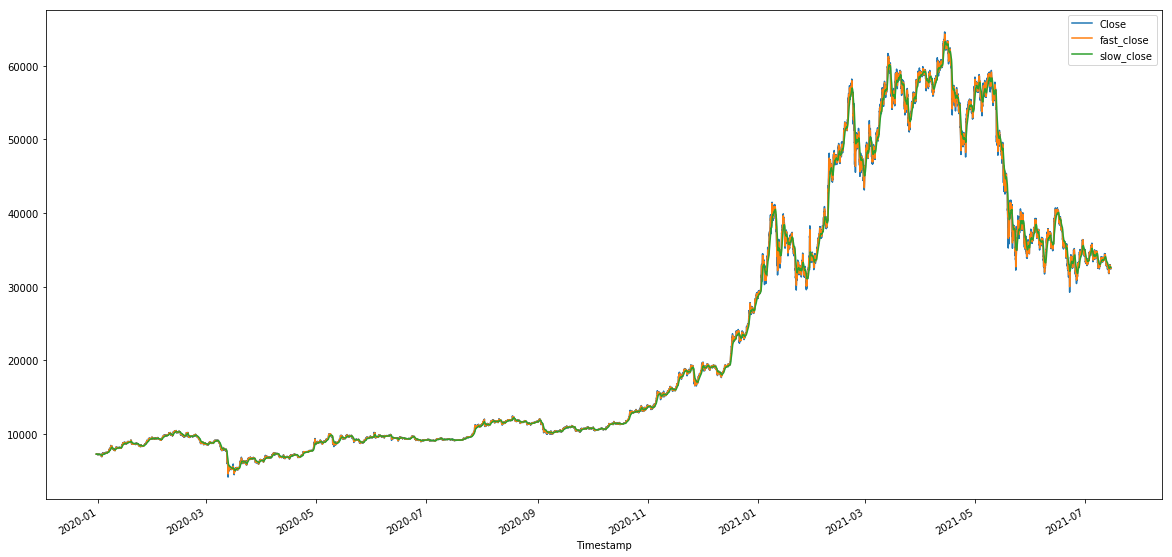

In [15]:
# Plot the EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

### Volatility

In [16]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
btc_df["fast_vol"] = btc_df["hourly_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["hourly_return"].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = btc_df["vol_trend_long"] + btc_df["vol_trend_short"]

# Display sample data
btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Timestamp,,,,,,,,,,,,,,,,,
2019-12-31 00:00:00,7246.00,7255.00,7200.00,7251.00,1792.533352,NaN,NaN,7251.000000,7251.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2019-12-31 01:00:00,7251.00,7269.00,7245.00,7265.40,906.250932,0.001986,NaN,7260.600000,7258.449433,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2019-12-31 02:00:00,7264.96,7266.74,7225.34,7246.99,735.587624,-0.002534,NaN,7252.822857,7254.362010,0.0,-1.0,-1.0,0.003196,0.003196,0.0,0.0,0.0
2019-12-31 03:00:00,7247.01,7250.00,7221.00,7236.39,622.927341,-0.001463,NaN,7244.058667,7249.391649,0.0,-1.0,-1.0,0.001867,0.002314,1.0,0.0,1.0
2019-12-31 04:00:00,7236.60,7263.15,7228.40,7240.37,774.064951,0.000550,NaN,7242.154839,7247.328942,0.0,-1.0,-1.0,0.001682,0.001974,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15 05:00:00,32665.53,32665.53,32473.72,32583.90,923.639498,-0.002499,0.024425,32638.760657,32673.791582,0.0,-1.0,-1.0,0.002248,0.005348,1.0,0.0,1.0
2021-07-15 06:00:00,32582.71,32650.00,32366.12,32483.00,1404.628993,-0.003097,0.020340,32560.880329,32661.014841,0.0,-1.0,-1.0,0.001812,0.005219,1.0,0.0,1.0
2021-07-15 07:00:00,32483.00,32600.00,32359.65,32469.50,1675.703792,-0.000416,0.017215,32515.190164,32648.189665,0.0,-1.0,-1.0,0.001760,0.005041,1.0,0.0,1.0


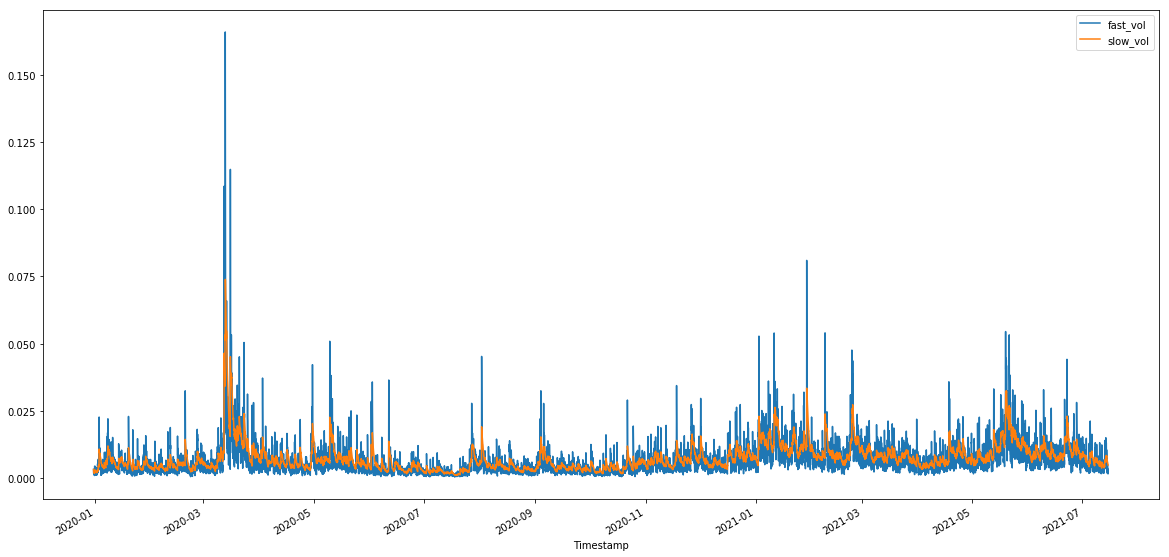

In [17]:
# Plot the EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

### Bollinger Bands

In [18]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Calculate bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], -1.0, 0.0)
btc_df["bollinger_signal"] = btc_df["bollinger_long"] + btc_df["bollinger_short"]

# Display sample data
btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-31 00:00:00,7246.00,7255.00,7200.00,7251.00,1792.533352,NaN,NaN,7251.000000,7251.000000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-12-31 01:00:00,7251.00,7269.00,7245.00,7265.40,906.250932,0.001986,NaN,7260.600000,7258.449433,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-12-31 02:00:00,7264.96,7266.74,7225.34,7246.99,735.587624,-0.002534,NaN,7252.822857,7254.362010,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-12-31 03:00:00,7247.01,7250.00,7221.00,7236.39,622.927341,-0.001463,NaN,7244.058667,7249.391649,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-12-31 04:00:00,7236.60,7263.15,7228.40,7240.37,774.064951,0.000550,NaN,7242.154839,7247.328942,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15 05:00:00,32665.53,32665.53,32473.72,32583.90,923.639498,-0.002499,0.024425,32638.760657,32673.791582,0.0,...,1.0,0.0,1.0,32729.3155,170.925933,32900.241433,32558.389567,0.0,0.0,0.0
2021-07-15 06:00:00,32582.71,32650.00,32366.12,32483.00,1404.628993,-0.003097,0.020340,32560.880329,32661.014841,0.0,...,1.0,0.0,1.0,32732.0865,166.159604,32898.246104,32565.926896,1.0,0.0,1.0
2021-07-15 07:00:00,32483.00,32600.00,32359.65,32469.50,1675.703792,-0.000416,0.017215,32515.190164,32648.189665,0.0,...,1.0,0.0,1.0,32732.9620,164.645321,32897.607321,32568.316679,1.0,0.0,1.0


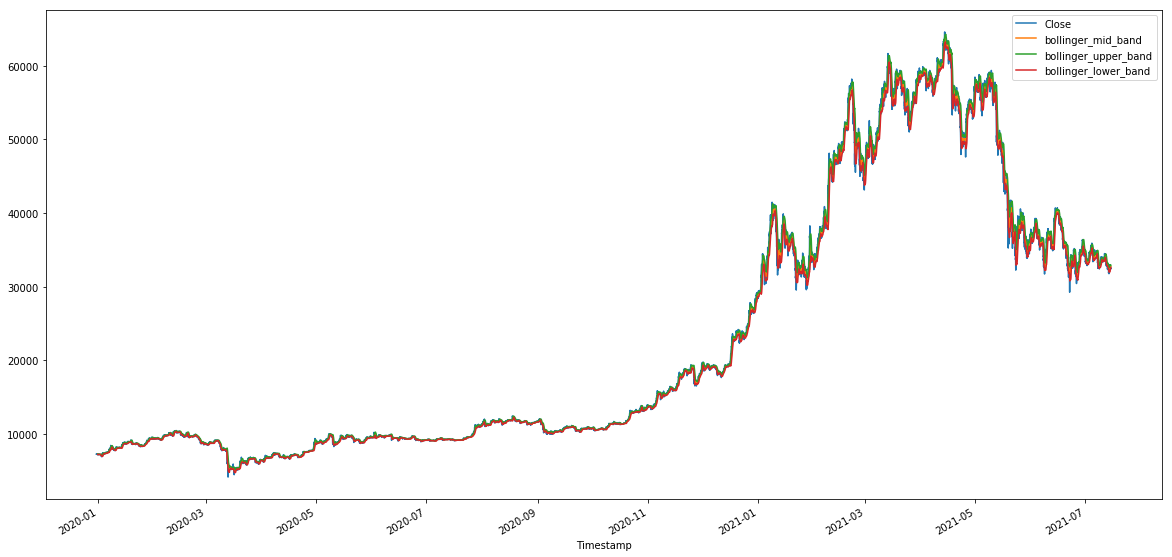

In [19]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [20]:
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

# Trading Signals

In [21]:
trading_signals_df = btc_df.copy()

In [23]:
# Set x variable list of features
x_var_list = ["crossover_signal", "vol_trend_signal", "bollinger_signal", "rsi"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-15 05:00:00,-1.0,1.0,0.0,46.983319
2021-07-15 06:00:00,-1.0,1.0,1.0,43.980084
2021-07-15 07:00:00,-1.0,1.0,1.0,43.578712
2021-07-15 08:00:00,-1.0,1.0,1.0,40.815563
2021-07-15 09:00:00,-1.0,1.0,1.0,44.539849


In [24]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2019-12-31 00:00:00,NaN,NaN,NaN,NaN
2019-12-31 01:00:00,0.0,0.0,0.0,NaN
2019-12-31 02:00:00,1.0,0.0,0.0,NaN
2019-12-31 03:00:00,-1.0,0.0,0.0,NaN
2019-12-31 04:00:00,-1.0,1.0,0.0,NaN


In [25]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,-0.002531,-0.010203,7185.049947,7208.084104,0.0,...,0.0,1.0,7214.2185,32.163582,7246.382082,7182.054918,1.0,0.0,0.0,41.476897
2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,0.005469,-0.006762,7200.659974,7208.740565,0.0,...,-1.0,1.0,7211.8290,29.966001,7241.795001,7181.862999,0.0,0.0,1.0,36.297612
2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,0.003683,-0.000571,7221.754987,7211.440232,1.0,...,-1.0,-1.0,7211.7225,29.845523,7241.568023,7181.876977,0.0,-1.0,0.0,50.612680
2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,-0.002463,-0.001573,7223.382493,7212.501317,1.0,...,-1.0,-1.0,7210.4545,28.631159,7239.085659,7181.823341,0.0,0.0,-1.0,57.566818
2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.001071,-0.003190,7220.326247,7212.870063,1.0,...,-1.0,-1.0,7209.8590,28.343603,7238.202603,7181.515397,0.0,0.0,0.0,52.249034


### Classification Problem

In [26]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

# Display sample data
trading_signals_df.head(1)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi,Positive Return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7195.24,7196.25,7175.46,7177.02,511.814901,-0.002531,-0.010203,7185.049947,7208.084104,0.0,...,1.0,7214.2185,32.163582,7246.382082,7182.054918,1.0,0.0,0.0,41.476897,0.0


In [27]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [28]:
trading_signals_df["Positive Return"].value_counts()

 0    10316
 1     1798
-1     1336
Name: Positive Return, dtype: int64

In [29]:
# Construct training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Construct testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-01-01
Training End: 2021-03-25 03:00:00
Testing Start: 2021-03-25 04:00:00
Testing End: 2021-07-15


In [30]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-03-24 23:00:00,-1.0,1.0,1.0,27.846050
2021-03-25 00:00:00,-1.0,-1.0,1.0,26.786721
2021-03-25 01:00:00,-1.0,-1.0,1.0,30.766643
2021-03-25 02:00:00,-1.0,-1.0,1.0,26.887290
2021-03-25 03:00:00,-1.0,-1.0,1.0,31.827343


Timestamp
2021-03-24 23:00:00    0
2021-03-25 00:00:00    0
2021-03-25 01:00:00   -1
2021-03-25 02:00:00    0
2021-03-25 03:00:00   -1
Name: Positive Return, dtype: int64

In [31]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-15 05:00:00,1.0,1.0,0.0,49.523833
2021-07-15 06:00:00,-1.0,1.0,0.0,46.983319
2021-07-15 07:00:00,-1.0,1.0,1.0,43.980084
2021-07-15 08:00:00,-1.0,1.0,1.0,43.578712
2021-07-15 09:00:00,-1.0,1.0,1.0,40.815563


Timestamp
2021-07-15 05:00:00    0
2021-07-15 06:00:00    0
2021-07-15 07:00:00    0
2021-07-15 08:00:00    0
2021-07-15 09:00:00    0
Name: Positive Return, dtype: int64

In [32]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    2519
 1     110
-1      60
Name: Predicted Value, dtype: int64

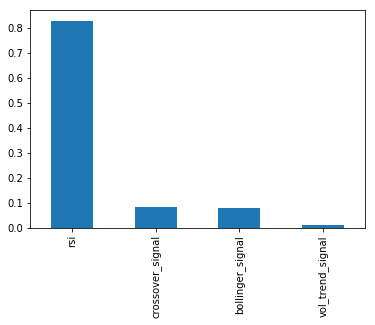

In [33]:
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [34]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [35]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0], dtype=int64)

In [36]:
results["Predicted Value"].value_counts()

 0    2519
 1     110
-1      60
Name: Predicted Value, dtype: int64

In [37]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

,Positive Return,Predicted Value
Timestamp,,
2021-03-25 04:00:00,0,0
2021-03-25 05:00:00,0,0
2021-03-25 06:00:00,0,0
2021-03-25 07:00:00,-1,0
2021-03-25 08:00:00,-1,-1
2021-03-25 09:00:00,-1,0
2021-03-25 10:00:00,-1,0
2021-03-25 11:00:00,-1,0
2021-03-25 12:00:00,-1,0


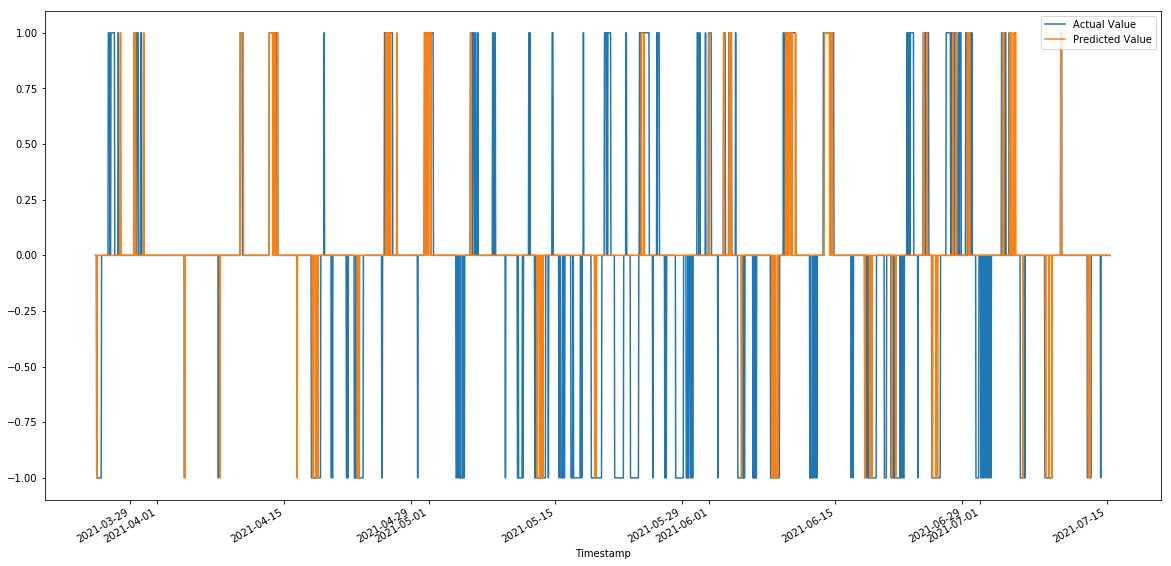

In [38]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

In [39]:
# Replace predicted values 0 to -1 to account for shorting
#results["Predicted Value"] = results["Predicted Value"].replace(0, -1)

# Display sample data
results

,Positive Return,Predicted Value,Actual Value
Timestamp,,,
2021-03-25 04:00:00,0,0,0
2021-03-25 05:00:00,0,0,0
2021-03-25 06:00:00,0,0,0
2021-03-25 07:00:00,-1,0,-1
2021-03-25 08:00:00,-1,-1,-1
...,...,...,...
2021-07-15 05:00:00,0,0,0
2021-07-15 06:00:00,0,0,0
2021-07-15 07:00:00,0,0,0


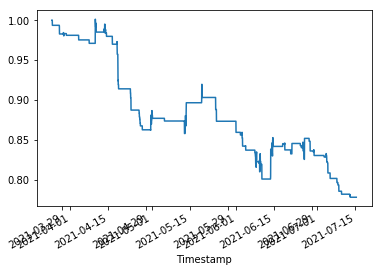

In [40]:
# Calculate cumulative return of the model
results['Return'] = trading_signals_df['hourly_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

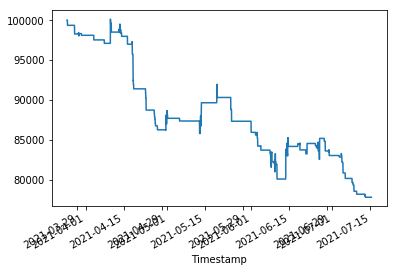

In [41]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

### How could we improve this?
- Different Timeframes
- More Features (ta library)
- More data
- Regression Problem vs Classification Problem
- Change the classes we are trying to predict
- Change the trading decision currently buy if > 50% to go up, sell if < 50% to go up

In [44]:
raw_df = btc_df.copy()

In [45]:
results['prob'] = model.predict_proba(X_test)[:,1]

In [46]:
results

,Positive Return,Predicted Value,Actual Value,Return,prob
Timestamp,,,,,
2021-03-25 04:00:00,0,0,0,0.002458,0.525014
2021-03-25 05:00:00,0,0,0,0.008329,0.609457
2021-03-25 06:00:00,0,0,0,0.005491,0.622437
2021-03-25 07:00:00,-1,0,-1,-0.013303,0.800392
2021-03-25 08:00:00,-1,-1,-1,0.006517,0.471879
...,...,...,...,...,...
2021-07-15 05:00:00,0,0,0,-0.002499,0.936347
2021-07-15 06:00:00,0,0,0,-0.003097,0.913156
2021-07-15 07:00:00,0,0,0,-0.000416,0.938938


In [47]:
results['probability_quantile'] = pd.qcut(results['prob'],10,duplicates='drop')
results.groupby('probability_quantile').agg(['count','mean'])[['Return']]

Return          
                      count      mean
probability_quantile                 
(0.0603, 0.523]         302  0.000156
(0.523, 0.636]          238  0.000188
(0.636, 0.758]          267 -0.000441
(0.758, 0.827]          271 -0.000002
(0.827, 0.9]            269 -0.000553
(0.9, 0.913]            280 -0.000038
(0.913, 0.915]          295 -0.000605
(0.915, 0.93]           230  0.000222
(0.93, 0.936]           272 -0.000062
(0.936, 0.967]          265 -0.000026